# Opensource Dataset settings:

In [1]:
# Define if you want to download data from the original database or use the dataset one already provided and preprocessed
# Use:
# 'load': If you want to load the datase from the directory
# 'download': To download data from the database and process the images
dataset_load_method = 'load'

# Define if you want to save the dataset to a file
save_dataset = False

# Define if you want to load the trained classifiers from the directory
load_classifiers = False

# Define if you want to save the trained classifiers to a file
save_classifiers = True

# Define if you want to save classification test output to a file
save_results = True
if (save_results):
    result_output_file = open('result_output.txt','w') 

# Define if you want to print errors and warnings
enable_error_output = False

In [2]:
import os
os.system('pip install plotly')
os.system('pip install opencv-contrib-python')

0

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import scipy
import sklearn
import pandas as pd
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import binarize
from sklearn.neural_network import BernoulliRBM, MLPClassifier
from sklearn.datasets import fetch_mldata
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from skimage import data, color, exposure, measure
from skimage.transform import resize
from skimage.feature import hog
from sklearn.manifold import TSNE
from sklearn.externals import joblib
import urllib
from io import StringIO
import cv2
from scipy import ndimage
from difflib import SequenceMatcher
from sys import stdout
from IPython.display import clear_output

Pretty printing the percentage of training/ test function:

In [4]:
def print_percentage(prct, msg=None):
    if (prct > 100 or prct < 0):
        return
    clear_output(wait=True)
    if (msg == None):
        stdout.write("Progress: [")
    else:
        stdout.write(msg+" [")
    end = int(int(prct)/10)
    for i in range(0, end):
        stdout.write("=")
    for i in range(end, 10):
        stdout.write(" ")
    stdout.write("] "+str(prct)+"%")
    stdout.flush()

# Reading the data in from the CSV

In [5]:
df=pd.read_csv('first_and_last_names_fix.csv', sep=',',header=None)

Delete any underscore values or underlines to the word

In [6]:
# Here we are applying filters and making it clean.
def delborders(crop):
    cropf = ndimage.gaussian_filter(crop, 0.5)
    cropbin = (cropf<0.8)
    labeled, nr_objects = ndimage.label(cropbin)
    labels_to_delete = []
    for i in range(0, labeled.shape[1]):
        if (labeled[labeled.shape[0]-1][i] > 0):
            labels_to_delete.append(labeled[labeled.shape[0]-1][i])
    
    label_in_delete = False
    for x in range(0, labeled.shape[1]):
        for y in range(0, labeled.shape[0]):
            label_in_delete = False
            for l in range(0, len(labels_to_delete)):
                if (labeled[y][x] == labels_to_delete[l]):
                    label_in_delete = True
            
            if(label_in_delete):
                crop[y][x] = 1.0
    
    return crop

In this dataset, there is some machine text: 
The *_getcrop_* function obtains an image from an entry of the database and returns the image in grayscale and cropped to show just the name part.
The handwriting data will only have handwriting, so we need not worry about the cropping image. 

In [7]:
def getcrop(n):
    try: 
        urllib.request.urlretrieve(df[1][n], "temp.jpg")
    except urllib.error.URLError as e:
        return None, False
    img = cv2.imread('temp.jpg')
    imgh, imgw = img.shape[:-1]
    img_rgb = img.copy()
    template = cv2.imread('template.png')
    h, w = template.shape[:-1]

    template_match_success = False
    res = cv2.matchTemplate(img_rgb, template, cv2.TM_CCOEFF_NORMED)
    threshold = .7
    loc = np.where(res >= threshold)
    for pt in zip(*loc[::-1]):
        print(pt)# Switch collumns and rows
        cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0, 0, 255), 2)
        croph1 = pt[1]
        croph2 = pt[1]+h
        cropw = pt[0] + w
        template_match_success = True

    if (not template_match_success):
        #Template matching has failed so return...
        return img, False

    if (df[3][n] == 'first' or df[3][n] == 'last'):
        crop = img.copy()[max(croph1-6, 0):min(croph2+6, imgh), cropw:imgw]
    else:
        crop = img.copy()[max(min(croph2+4, imgh-1), 0):imgh, :]
        
    crop = color.rgb2gray(crop)
    if (df[3][n] == 'first_b' or df[3][n] == 'last_b'):
        crop = delborders(crop)
    return crop, True

Next we define the gen_dataset function, this function creates a binarized image list "_data_" and a label list "_labels_" from the first _n_ entries of the database (if not specified uses all the entries of the database) using the crops of the _getcrop_ function and its corresponding label on that index.

In [8]:
def gen_dataset(n=df.shape[0]):
    data = []
    labels = []
    for i in range(1, n):
        crop, success = getcrop(i)
        if (success):
            data.append(crop)
            labels.append(df[2][i])
        else:
            if (enable_error_output):
                print("[WARNING] Template matching has failed for image: "+str(i))
        print_percentage((i*100/(n-1)), "Fetched "+str(i)+" images:")
    
    print_percentage(100, "Fetched "+str(n-1)+" images:")
    print("")
    print("Finished!")
    return data, labels

Obtaining the dataset

Now we can download and create the whole dataset and its corresponding label list or load the dataset from the saved files. The process takes a while to complete...


In [9]:
# Obtain dataset from original data if defined (we can define how much data of the 
# original database we want to use to the function or leave it blank to use all the data)
if (dataset_load_method == 'download'):
    dataset, labels = gen_dataset(10000)

# Load dataset from files
if (dataset_load_method == 'load'):
    dataset = np.load("HandwrittenNames_data.npz")['data']
    labels = np.load("HandwrittenNames_labels.npz")['data']

If specified, the generated dataset can be saved to .npz files using these functions.

In [10]:
# Save dataset to a file if defined
if (save_dataset):
    np.savez("HandwrittenNames_data.npz", data=dataset)
    np.savez("HandwrittenNames_labels.npz", data=labels)

We can plot some images and print their corresponding labels to check that everything is correct: 

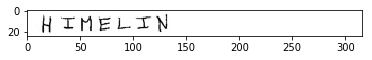

HIMELIN
<class 'numpy.str_'>
<class 'numpy.ndarray'>


In [11]:
# Change selection to plot a different image and label
selection = 0
plt.imshow(dataset[selection], cmap='gray')
plt.show()
print(labels[selection])
print(str(type(labels[0])))
print(type(dataset[selection]))

### get_labels

This function labels the connected components in an image by binarizing it and running a clustering method, it returns the labels and the number of labels it detects.

In [12]:
def get_labels(crop):
    img = crop.copy() # gray-scale image

    # You could smooth the image (to remove small objects) but we saw better results without using it...
    # blur_radius = 0.5
    # imgf = ndimage.gaussian_filter(img, blur_radius)

    threshold = 0.8

    # Find connected components
    labeled, nr_objects = ndimage.label(img<threshold) 
    #print("Number of objects is " +str(nr_objects))

    return labeled, nr_objects

### get_bboxes

This function gets the bounding boxes to cut each character correctly given the labels obtained from get_labels. It returns a list of each character's bounding boxes (2 2D points).

In [13]:
def get_bboxes(labeled, nr_objects):
    bboxes = np.zeros((nr_objects, 2, 2), dtype='int')

    x1, y1, x2, y2 = 0, labeled.shape[0], 0, 0
    coord = 0
    cont = 0
    ytop, ybot = 0, 0
    nzero, firstb = False, False

    for x in range(0, labeled.shape[1]):
        nzero, firstb = False, False
        ytop, ybot = 0, 0
        for y in range(0, labeled.shape[0]):
            if (labeled[y][x] > 0):
                nzero = True
                if (not firstb):
                    ytop = y
                    firstb = True
                ybot = y

        if (nzero):
            if (ytop < y1):
                y1 = ytop
            if (ybot > y2):
                y2 = ybot
            if (coord == 0):
                x1 = x
                coord = 1
            elif (coord == 1):
                x2 = x
        elif ((not nzero) and (coord == 1)):
            bboxes[cont][0] = [x1, y1]
            bboxes[cont][1] = [x2, y2]
            cont += 1
            coord = 0
            x1, y1, x2, y2 = 0, labeled.shape[0], 0, 0

    bboxes = bboxes[0:cont]
    return bboxes, cont

### crop_characters

Given an image and character bounding boxes this function crops each character in an image and returns each character's corresponding binarized image in a list.

In [14]:
def crop_characters(img, bboxes, n):
    characters = []
    for i in range(0, n):
        c = img.copy()[bboxes[i][0][1]:bboxes[i][1][1], bboxes[i][0][0]:bboxes[i][1][0]]
        if (c.shape[0] != 0 and c.shape[1] != 0):
            c = resize(c, (28, 28), mode='constant', cval=1.0, clip=True)
            characters.append((c<0.80).reshape(784))
    return characters, len(characters)

### labelsep

Separates a full name label into a character list. Useful for the training part to have the labels of each character.

In [15]:
def labelsep(label):
    if (type(label) is str or type(label) is np.str_):
        decomposed_label = list(label)
        labels = []
        for i in range(0, len(decomposed_label)):
            if (decomposed_label[i] != ' '):
                labels.append(decomposed_label[i])
        return labels
    else:
        return []

### get_characters

Given an image from the dataset and its label this function splits each character into one image and a label. The img_only variant doesn't return the labels (useful when testing with full names to save some memory and time).

In [16]:
def get_characters(image, label):
    labeled, nr_objects = get_labels(image)
    bboxes, n = get_bboxes(labeled, nr_objects)
    characters, n_chars = crop_characters(image, bboxes, n)
    labels = labelsep(label)
    return characters, labels[0:n_chars]

def get_characters_img_only(image):
    labeled, nr_objects = get_labels(image)
    bboxes, n = get_bboxes(labeled, nr_objects)
    characters, n_chars = crop_characters(image, bboxes, n)
    return characters

We can check if it extracts correctly all the data with these plots and prints

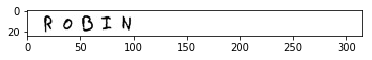

ROBIN


In [17]:
selection = 1
plt.imshow(dataset[selection], cmap='gray')
plt.show()
print(labels[selection])

In [18]:
characters, charlabels = get_characters(dataset[selection], labels[selection])

/users/mscdsa2018/dsj1/fast_rcnn/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning:

Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.



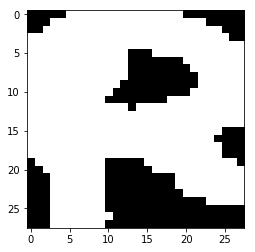

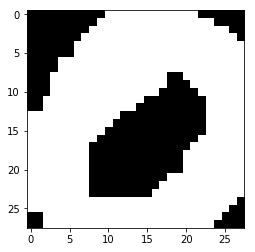

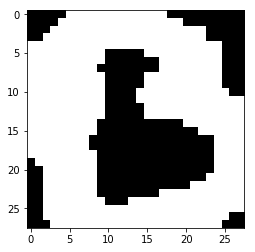

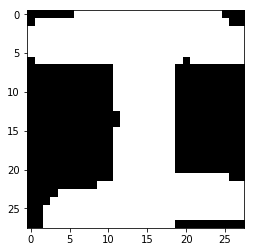

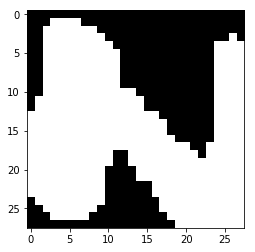

['R', 'O', 'B', 'I', 'N']


In [19]:
for i in range(0, len(characters)):
    plt.imshow(characters[i].reshape(28,28), cmap='gray')
    plt.show()
    
print(str(charlabels))

In [20]:
# Define if we want to print status of the training process
verbose_classifiers = True

## Defining our model

Multi-layer perceptron (will be trained with PCA features later on)


In [21]:
# MLP Classifier with PCA (Principal Component Analisis) features
mlp_classifier_PCA = MLPClassifier(hidden_layer_sizes=(300,400,150), max_iter=5000, tol=0.0001, random_state=1, verbose=verbose_classifiers)

### Splitting the dataset into train and test batches

We divide the dataset into 80% train 20% test batches:

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(dataset, labels, test_size=0.2, random_state=0)

In [23]:
print("Train batch lenghts:")
print("X_train size: "+str(len(X_train)))
print("Y_train size: "+str(len(Y_train)))
print("")
print("Test batch lenghts:")
print("X_test size: "+str(len(X_test)))
print("Y_test size: "+str(len(Y_test)))

Train batch lenghts:
X_train size: 7985
Y_train size: 7985

Test batch lenghts:
X_test size: 1997
Y_test size: 1997


### Processing the train and test batches for characters

We process the train and test batches to divide the batches into single character batches instead of full names,
this is needed to train and will be useful in case of the test to test per character precision later on

In [24]:
X_train_chars = []
Y_train_chars = []
Train_with_inconsistencies = []
z = 0
for i in range(0, len(X_train)):
    print_percentage(i*100/len(X_train), "Processing train image "+ str(i)+" :")
    characters, charlabels = get_characters(X_train[i], Y_train[i])
    if (len(characters) != len(charlabels) or len(characters) == 0 or len(charlabels) == 0):
        if (enable_error_output):
            print("[Warning] Input number "+str(i)+" inconsistent! Skipping this one...")
        Train_with_inconsistencies.append(i)
        z += 1
    else:
        X_train_chars.extend(characters)
        Y_train_chars.extend(charlabels)

print_percentage(100, "Processing train image "+ str(len(X_train))+" :")
print("")
print(str(100-(z*100/len(X_train)))+"% of the data in train batch correctly extracted.")

Processing train image 7985 : [==========] 100%
94.16405760801503% of the data in train batch correctly extracted.


In [25]:
X_test_chars = []
Y_test_chars = []
Test_without_inconsistencies = []
z = 0
for i in range(0, len(X_test)):
    print_percentage(i*100/len(X_test), "Processing test image "+ str(i)+" :")
    characters, charlabels = get_characters(X_test[i], Y_test[i])
    if (len(characters) != len(charlabels) or len(characters) == 0 or len(charlabels) == 0):
        if (enable_error_output):
            print("[Warning] Input number "+str(i)+" inconsistent! Skipping this one...")
        z += 1
    else:
        X_test_chars.extend(characters)
        Y_test_chars.extend(charlabels)
        Test_without_inconsistencies.append(i)

print_percentage(100, "Processing train image "+ str(len(X_test))+" :")
print("")
print(str(100-(z*100/len(X_test)))+"% of the data in test batch correctly extracted.")

Processing train image 1997 : [==========] 100%
94.04106159238859% of the data in test batch correctly extracted.


In [26]:
print("Character splitted train batch lenghts:")
print("X_train_chars size: "+str(len(X_train_chars)))
print("Y_train_chars size: "+str(len(Y_train_chars)))

Character splitted train batch lenghts:
X_train_chars size: 43802
Y_train_chars size: 43802


### Transform the data to extract Principal Component Analysis features

We transform the data to extract Principal Component Analysis features for the MLP_PCA classifier.

In [27]:
# Standardising the values
Scaler = StandardScaler().fit(X_train_chars)
X_pca_train = Scaler.transform(X_train_chars)
# Call the PCA method with 100 components. 
pca = PCA(n_components=100)
pca.fit(X_pca_train)
P_train = pca.transform(X_pca_train)

# Standardising the values
X_pca_test = Scaler.transform(X_test_chars)

# Call the PCA method with 100 components. 
P_test = pca.transform(X_pca_test)

In [28]:
# We also define a function in case we need to transform something later
def PCA_transform(chars):
    # Standardising the values
    X_pca = Scaler.transform(chars)

    # Call the PCA method with 100 components. 
    P = pca.transform(X_pca)
    return P

### Training/loading classifiers

We feed the train characters and train character labels to each classifier or load the already trained classifiers from files

In [29]:
if (not load_classifiers):
    mlp_classifier_PCA.fit(P_train,Y_train_chars)
else:
    mlp_classifier_PCA = joblib.load('MLP_PCA.pkl')

Iteration 1, loss = 0.66202481
Iteration 2, loss = 0.36720914
Iteration 3, loss = 0.29512072
Iteration 4, loss = 0.24631425
Iteration 5, loss = 0.20192125
Iteration 6, loss = 0.16924244
Iteration 7, loss = 0.13802454
Iteration 8, loss = 0.10699425
Iteration 9, loss = 0.08901338
Iteration 10, loss = 0.06992461
Iteration 11, loss = 0.05742846
Iteration 12, loss = 0.04488643
Iteration 13, loss = 0.04091145
Iteration 14, loss = 0.03771724
Iteration 15, loss = 0.03844675
Iteration 16, loss = 0.04194183
Iteration 17, loss = 0.03309565
Iteration 18, loss = 0.04131601
Iteration 19, loss = 0.03087971
Iteration 20, loss = 0.02715498
Iteration 21, loss = 0.02328126
Iteration 22, loss = 0.02685835
Iteration 23, loss = 0.02981081
Iteration 24, loss = 0.03414911
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


### Saving the classifiers

If enabled, this will save the trained models to files.

In [30]:
# Save the classifiers if enabled:
if (save_classifiers):
    joblib.dump(mlp_classifier_PCA, 'MLP_PCA.pkl')


### Functions for testing results later

predict_full_name given a full name image and a classifier divides the image into characters and asks the classifier to predict it, afterwards chains the predictions of each characters into a full string.

In [31]:
# transform should be 'hog' for MLP_HOG classifier and 'pca' for MLP_PCA classifier, otherwise None
def predict_full_name(name, classifier, transform=None):
    characters = get_characters_img_only(name)
    if (transform == 'pca'):
        prediction = classifier.predict(PCA_transform(characters))
    else:
        prediction = classifier.predict(characters)
    strg = ''
    for i in range(0, len(prediction)):
        strg = strg+prediction[i]
    return strg

predict_full_names gets the prediction for each consistent test data and returns the correct ratio and correlation ratio.

In [32]:
# transform should be 'hog' for MLP_HOG classifier and 'pca' for MLP_PCA classifier, otherwise None
def predict_full_names(classifier, transform=None):
    correlation=0.0
    correct = 0
    for i in range(0,len(Test_without_inconsistencies)):
        predicted_name = predict_full_name(X_test[Test_without_inconsistencies[i]], classifier, transform)
        if (predicted_name == Y_test[Test_without_inconsistencies[i]]):
            correct += 1
        correlation += similar(predicted_name, Y_test[Test_without_inconsistencies[i]])
        print_percentage(i*100/len(X_test),"Making predictions "+str(i)+"/"+str(len(X_test))+":")
    print_percentage(100,"Making predictions "+str(len(X_test))+"/"+str(len(X_test))+":")
    return (correct/len(Test_without_inconsistencies)), (correlation/len(Test_without_inconsistencies))

In [33]:
def similar(a,b):
        return SequenceMatcher(None,a,b).ratio()

### Testing character recognintion

We will test now individual character recognition scores for each classifier using the test batch.

In [34]:
mlp_prediction_PCA = mlp_classifier_PCA.predict(P_test)

In [35]:
print("PCA + MLP classification:\n%s\n" % (metrics.classification_report(Y_test_chars, mlp_prediction_PCA)))

if (save_results):
    result_output_file.write("\nPCA + MLP classification:\n%s\n" % (metrics.classification_report(Y_test_chars, mlp_prediction_PCA)))
    

PCA + MLP classification:
             precision    recall  f1-score   support

          -       0.59      0.42      0.49        24
          A       0.96      0.90      0.93      1686
          B       0.73      0.85      0.78        98
          C       0.89      0.93      0.91       305
          D       0.88      0.82      0.85       183
          E       0.95      0.94      0.95      1471
          F       0.65      0.61      0.63        61
          G       0.91      0.80      0.85       110
          H       0.77      0.87      0.82       327
          I       0.91      0.91      0.91       979
          J       0.77      0.92      0.84       109
          K       0.74      0.81      0.77        48
          L       0.94      0.96      0.95      1000
          M       0.86      0.87      0.86       571
          N       0.94      0.91      0.93      1060
          O       0.92      0.93      0.92       598
          P       0.70      0.82      0.75        93
          Q       0

### Testing full name recognition

We will test now full name recognition scores using the consistent test batch.

In [36]:
correct_mlp_PCA, corr_mlp_PCA = predict_full_names(mlp_classifier_PCA, 'pca')

Making predictions 1997/1997: [==========] 100%

In [37]:
print("Full name test results: ")
print("========================================================================")
print("| Classifier            | Correct percentage      | Correlation ratio  |")
print("========================================================================")
print("| MLP with PCA features | "+str(correct_mlp_PCA)+"     | "+str(corr_mlp_PCA)+" |")
print("========================================================================")

if (save_results):
    result_output_file.write("\n\nFull name test results: ")
    result_output_file.write("\n========================================================================")
    result_output_file.write("\n| Classifier            | Correct percentage      | Correlation ratio  |")
    result_output_file.write("\n========================================================================")
    result_output_file.write("\n| MLP with PCA features | "+str(correct_mlp_PCA)+"     | "+str(corr_mlp_PCA)+" |")
    result_output_file.write("\n========================================================================")

Full name test results: 
| Classifier            | Correct percentage      | Correlation ratio  |
| MLP with PCA features | 0.6283280085197018     | 0.9115995563800039 |


### Visual testing

We can see some predictions visually here by adding indexes to the "indexes" list and for each test data selected in "indexes" we will see the predictions of each classifier.

> Image:


/users/mscdsa2018/dsj1/fast_rcnn/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning:

Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.



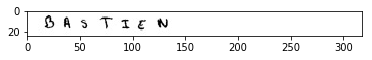

MLP with PCA features predicted: BABTIEN

> Image:


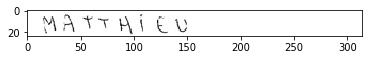

MLP with PCA features predicted: MATTHIEU

> Image:


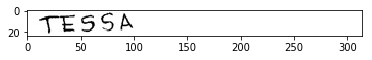

MLP with PCA features predicted: TSSA

> Image:


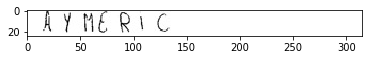

MLP with PCA features predicted: AYMERIC

> Image:


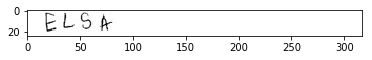

MLP with PCA features predicted: ELSA



In [38]:
indexes = [8, 10, 12, 14, 16]
for ind in indexes:
    mlp_pca_predict = predict_full_name(X_test[ind], mlp_classifier_PCA, 'pca')
    
    print("> Image:")
    plt.imshow(X_test[ind], cmap='gray')
    plt.show()
    print("MLP with PCA features predicted: "+mlp_pca_predict)
    print("")
    
    if (save_results):
        result_output_file.write("\n\n> Real label: "+Y_test[ind])
        result_output_file.write("\nMLP with PCA features predicted: "+mlp_pca_predict)
        result_output_file.write("\n")

## Saving this trained model for further usage.

In [39]:
if (save_results):
    result_output_file.close()

In [40]:
from sklearn.externals import joblib
joblib.dump(mlp_classifier_PCA, 'name_recognizer.pkl') 

['name_recognizer.pkl']

## Reading custom input

<class 'numpy.ndarray'>


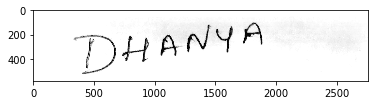

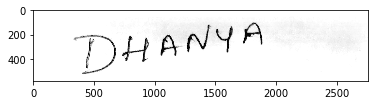

In [41]:
names_recog = joblib.load('name_recognizer.pkl')
img = cv2.imread('train1.jpg',0)
img = delborders(img)
print(type(img))
plt.imshow(img,cmap='gray')
plt.show()
img = cv2.imread('train1.jpg',0)
img = delborders(img)
plt.imshow(img,cmap='gray')
plt.show()

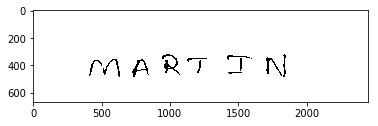

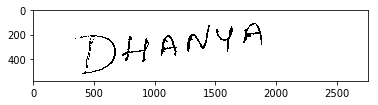

In [42]:
from skimage.filters import try_all_threshold, threshold_isodata
img = cv2.imread('train2.jpg',0)
th = threshold_isodata(img, nbins=256, return_all=False)
image = img > th
plt.imshow(image,cmap='gray')
plt.show()
img2 = cv2.imread('train1.jpg',0)
th2 = threshold_isodata(img2, nbins=256, return_all=False)
image2 = img2 > th2
plt.imshow(image2,cmap='gray')
plt.show()


In [43]:
# For filtered image
names_recog = joblib.load('name_recognizer.pkl')
mlp_pca_predict = predict_full_name(image, names_recog, 'pca')
print(mlp_pca_predict)

# For filtered image
mlp_pca_predict1 = predict_full_name(image2, names_recog, 'pca')
print(mlp_pca_predict1)

/users/mscdsa2018/dsj1/fast_rcnn/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning:

Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.



TMARTJRI
ETEUIAIYA
